In [1]:
# Standard imports
import sys
import warnings
warnings.simplefilter('ignore')
import os
import pandas as pd
import numpy as np
import textwrap
import matplotlib.pyplot as plt
%matplotlib inline

# ML
import tensorflow_hub as hub
import tensorflow as tf
from langdetect import detect



SEED=1

# Plotly
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
import plotly.io as pio
init_notebook_mode(connected=True)

def matplotlib_to_plotly(cmap, pl_entries):
    h = 1.0/(pl_entries-1)
    pl_colorscale = []

    for k in range(pl_entries):
        C = list(map(np.uint8, np.array(cmap(k*h)[:3])*255))
        pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])

    return pl_colorscale

# Cell timing
# https://github.com/cpcloud/ipython-autotime
%load_ext autotime

# Amazon product reviews

* https://s3.amazonaws.com/amazon-reviews-pds/readme.html

```
wget https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Camera_v1_00.tsv.gz
gunzip amazon_reviews_us_Camera_v1_00.tsv.gz
```

In [2]:
# Load our dataset (first time)
df = pd.read_csv('data/amazon_reviews_us_Camera_v1_00.tsv', sep='\t', error_bad_lines=False)
df = df.loc[df.product_title=='GoPro Head Strap Mount',['review_id','star_rating','review_headline','review_body','review_date']]
df['age'] = pd.datetime.today() - pd.to_datetime(df.review_date)
df['age'] = df.age.dt.days
df['review_body'] = df.review_body.map(lambda x: str(x))
df['review_headline'] = df.review_headline.map(lambda x: str(x))
df['textwrap'] = df.review_body.map(lambda x: '<br>'.join(textwrap.wrap(x, 64)))

# Save it
df.to_csv('output/gopro_strap.tsv', index=False, sep='\t')

b'Skipping line 85458: expected 15 fields, saw 22\nSkipping line 91161: expected 15 fields, saw 22\n'
b'Skipping line 166123: expected 15 fields, saw 22\n'
b'Skipping line 225458: expected 15 fields, saw 22\nSkipping line 229936: expected 15 fields, saw 22\nSkipping line 259297: expected 15 fields, saw 22\n'
b'Skipping line 284728: expected 15 fields, saw 22\nSkipping line 286334: expected 15 fields, saw 22\nSkipping line 293400: expected 15 fields, saw 22\nSkipping line 294415: expected 15 fields, saw 22\nSkipping line 308150: expected 15 fields, saw 22\nSkipping line 315022: expected 15 fields, saw 22\nSkipping line 315730: expected 15 fields, saw 22\nSkipping line 316071: expected 15 fields, saw 22\nSkipping line 326729: expected 15 fields, saw 22\n'
b'Skipping line 329101: expected 15 fields, saw 22\nSkipping line 333077: expected 15 fields, saw 22\nSkipping line 377031: expected 15 fields, saw 22\nSkipping line 389496: expected 15 fields, saw 22\nSkipping line 390486: expected 15 

time: 15.6 s


In [6]:
# Reload our dataset (if first step already done)
df = pd.read_csv('output/gopro_strap.tsv', sep='\t')
print(len(df))

sentences = df.review_body.tolist()

5609
time: 40.1 ms


In [5]:
# Load Google model from Tensorflow Hub
guse = hub.Module("https://tfhub.dev/google/universal-sentence-encoder-large/3")

# Function which will take a list of strings (sentences) and return the GUSE vectors
def guse_vectors(x):
  embeddings = guse(x)
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    return sess.run(embeddings)

time: 1.47 s


In [7]:
# Generate GUSE vectors - batch process 2000 at a time
batch_size = 2000
sentences_batch = [sentences[i:i+batch_size] for i in range(0,len(sentences),batch_size)]
vectors_guse_batch = [guse_vectors(x) for x in sentences_batch]
vectors_guse = np.concatenate(vectors_guse_batch, axis=0)

time: 3min 43s


In [8]:
# Save vectors
np.save('output/vectors-gopro.npy', vectors_guse)

time: 64.6 ms


In [9]:
from sklearn.decomposition import PCA
embedding_pca = PCA(n_components=2).fit_transform(vectors_guse)

time: 85.8 ms


In [10]:
from sklearn.manifold import TSNE
embedding_tsne = TSNE(n_components=2, random_state=SEED).fit_transform(vectors_guse)

time: 3min 9s


In [11]:
import umap
embedding_umap = umap.UMAP(n_components=2, random_state=SEED).fit_transform(vectors_guse)

time: 16.6 s


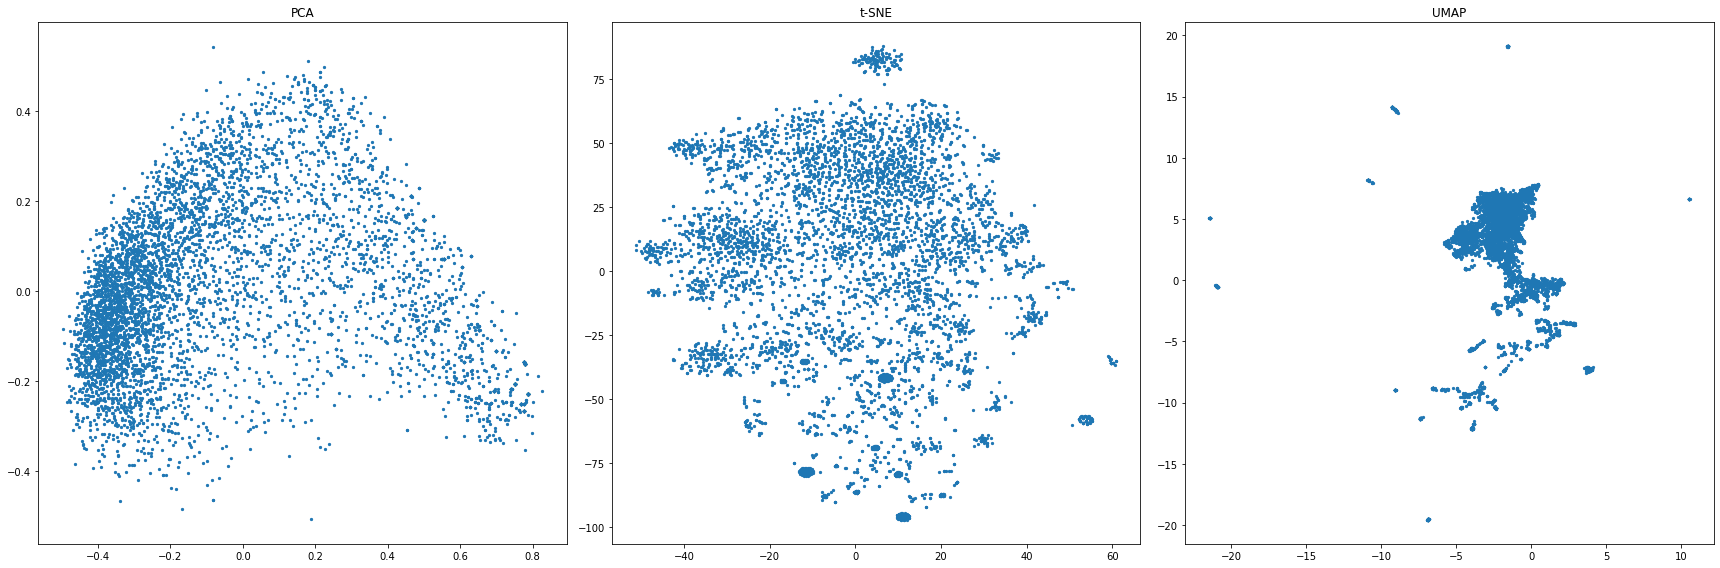

time: 868 ms


In [14]:
s = 5

plt.figure(figsize=(24,8), facecolor='w')

plt.subplot(131)
plt.scatter(embedding_pca[:,0], embedding_pca[:,1],s=s)
plt.title('PCA')

plt.subplot(132)
plt.scatter(embedding_tsne[:,0], embedding_tsne[:,1],s=s)
plt.title('t-SNE')

plt.subplot(133)
plt.scatter(embedding_umap[:,0], embedding_umap[:,1],s=s)
plt.title('UMAP')

plt.tight_layout()
plt.show()

In [15]:
nns = [2, 5, 10, 100, 500]
mds = [0.0, 0.1, 0.25, 0.5, 0.8, 0.99]

embedding_umap_hyper = []
for n_neighbours in nns:
    for min_dist in mds:
        embedding_umap_hyper.append(umap.UMAP(n_components=2,
                                              n_neighbors=n_neighbours,
                                              min_dist=min_dist,
                                              random_state=SEED).fit_transform(vectors_guse))
        


time: 10min 45s


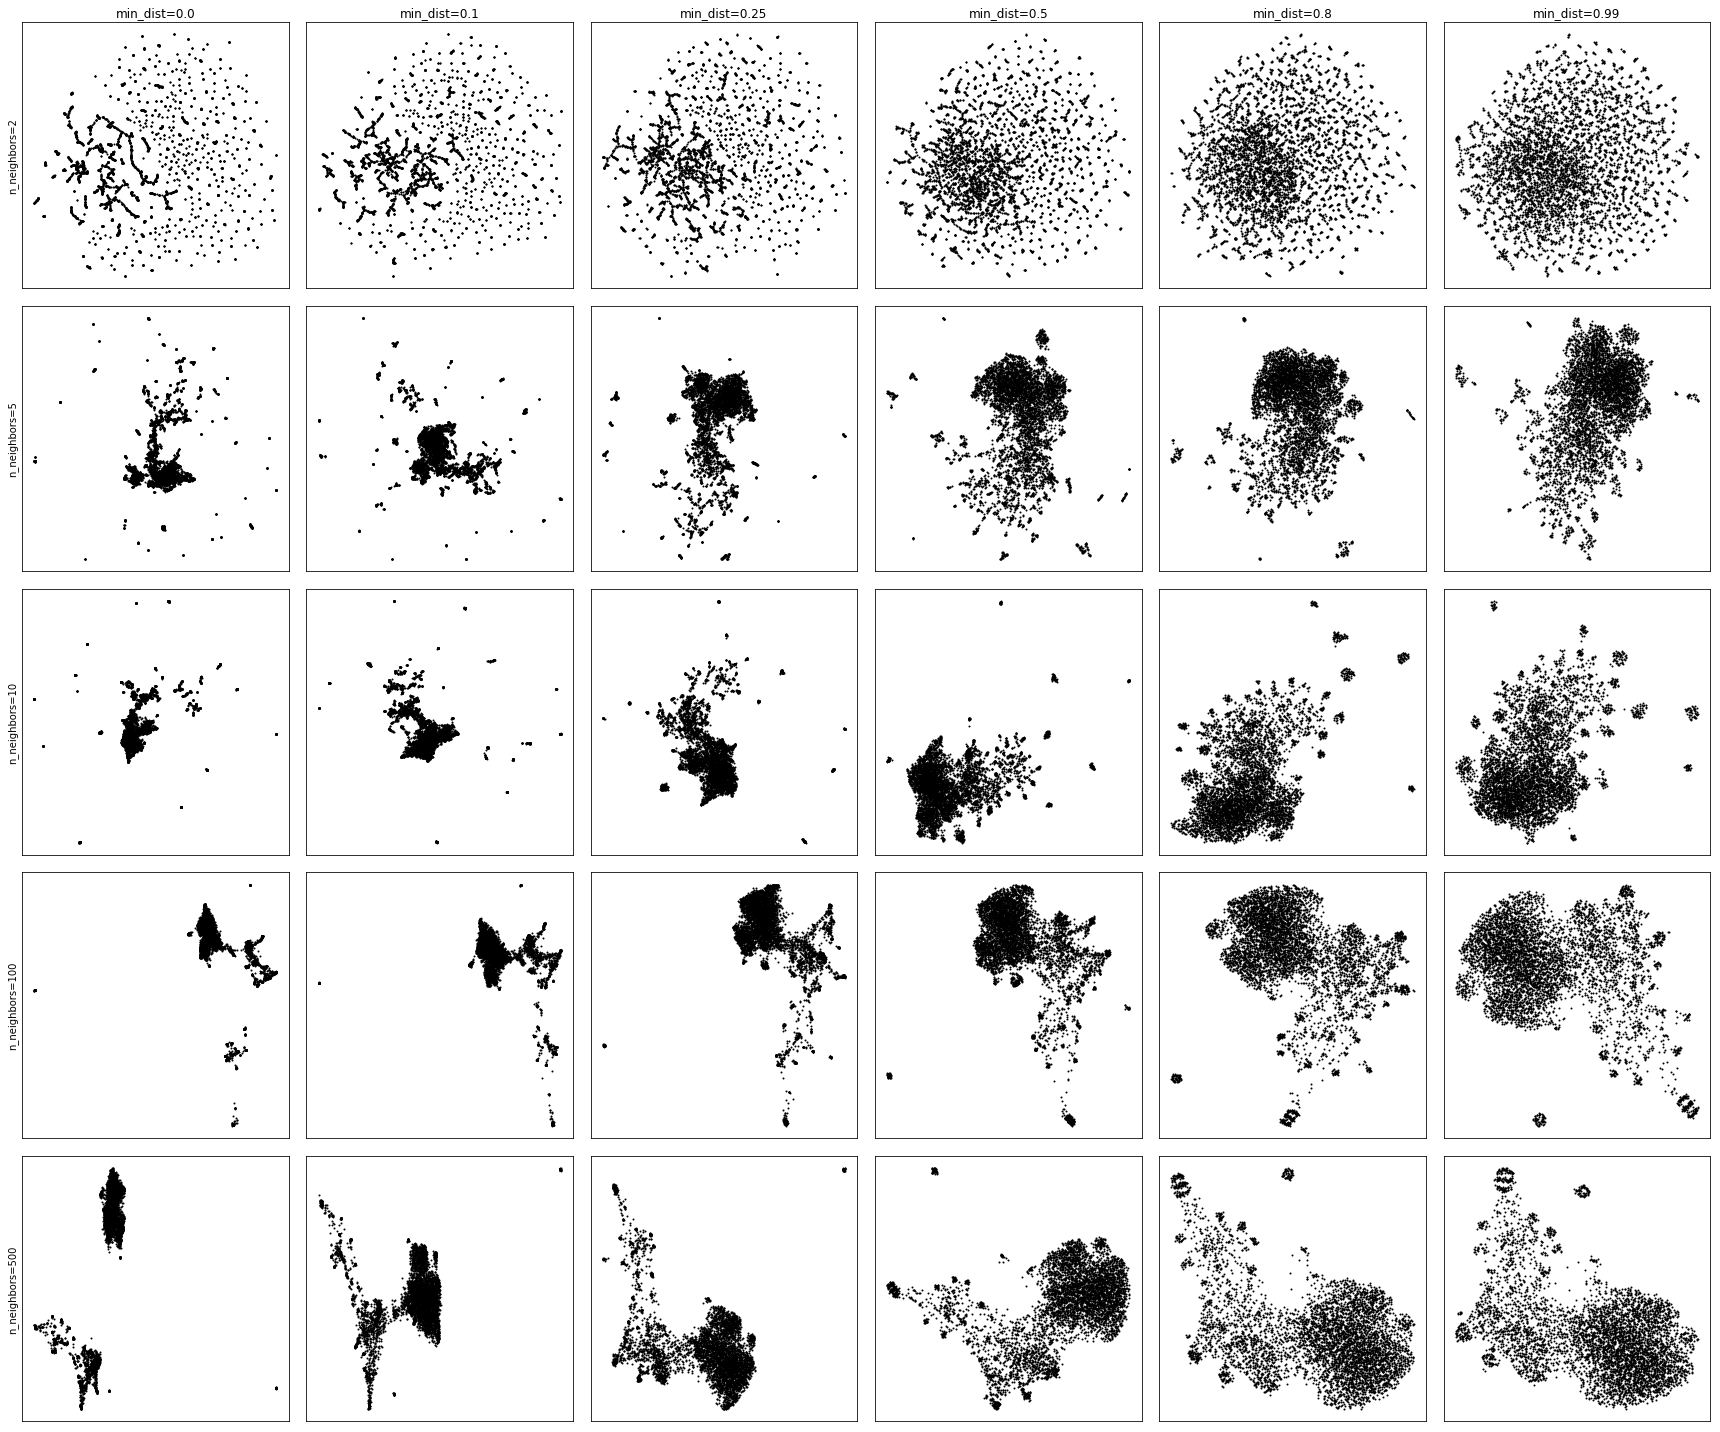

time: 3.24 s


In [20]:
plt.figure(figsize=(24,20))

for i in range(len(embedding_umap_hyper)):
    plt.subplot(5,6,i+1)
    plt.scatter(embedding_umap_hyper[i][:,0],embedding_umap_hyper[i][:,1], s=1, c='k')
    plt.xticks([],[])
    plt.yticks([],[])
    if i <= 5:
        plt.title('min_dist={}'.format(mds[i]))
    if i % 6 == 0:
        plt.ylabel('n_neighbors={}'.format(nns[int(i/6)]))
        
plt.tight_layout()
plt.show()

In [17]:
embedding_umap = umap.UMAP(n_components=2,
                           n_neighbors=100,
                           min_dist=0.8,
                           random_state=SEED).fit_transform(vectors_guse)

time: 30.8 s


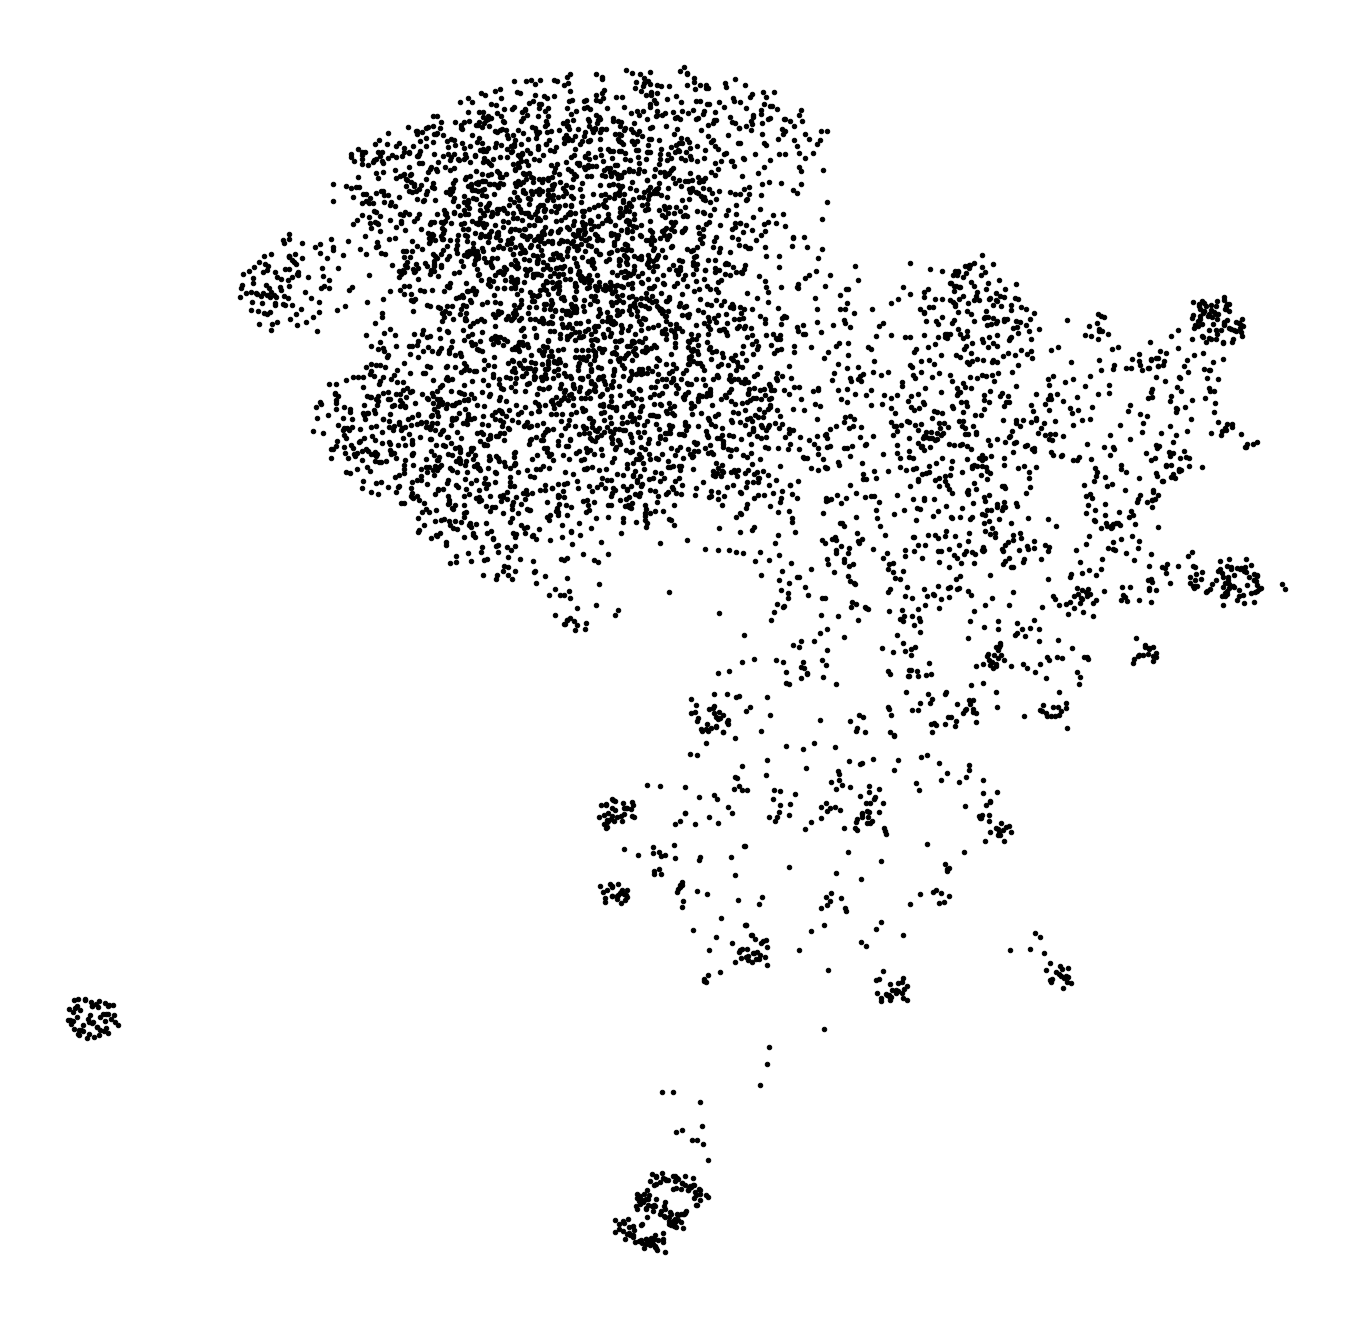

time: 831 ms


In [18]:
# Plot for presentation
plt.figure(figsize=(24,24), facecolor='w')
plt.scatter(embedding_umap[:,0], embedding_umap[:,1],s=20,c='k')
plt.axis('off')
plt.show()

In [19]:
# Plotly
layout = go.Layout(
    autosize=False,
    width=800,
    height=800,
    hovermode="closest"
)

data = [go.Scatter(
                x=embedding_umap[:,0],
                y=embedding_umap[:,1],
                text=df.textwrap,
                mode='markers',
                marker=dict(
                        size=5,
                        colorscale=matplotlib_to_plotly(plt.cm.viridis_r, 255),
                        color=0,
                        showscale=False
                )
)]

fig = go.Figure(data=data, layout=layout)

p = iplot(fig)

time: 936 ms


In [20]:
# Save this version, for github &  workshop
plot(fig, filename='output/viz1-gopro.html')

'output/viz1-gopro.html'

time: 398 ms


In [24]:
# Cull out those basic bits of feedback (in practice, we'd tally these up somewhere else)
df['word_count'] = df.review_body.map(lambda x: len(x.split(' ')))
idx = df.word_count > 3
vectors_cull = vectors_guse[idx,:]
embedding_cull = umap.UMAP(n_components=2, random_state=SEED).fit_transform(vectors_cull)

time: 9.83 s


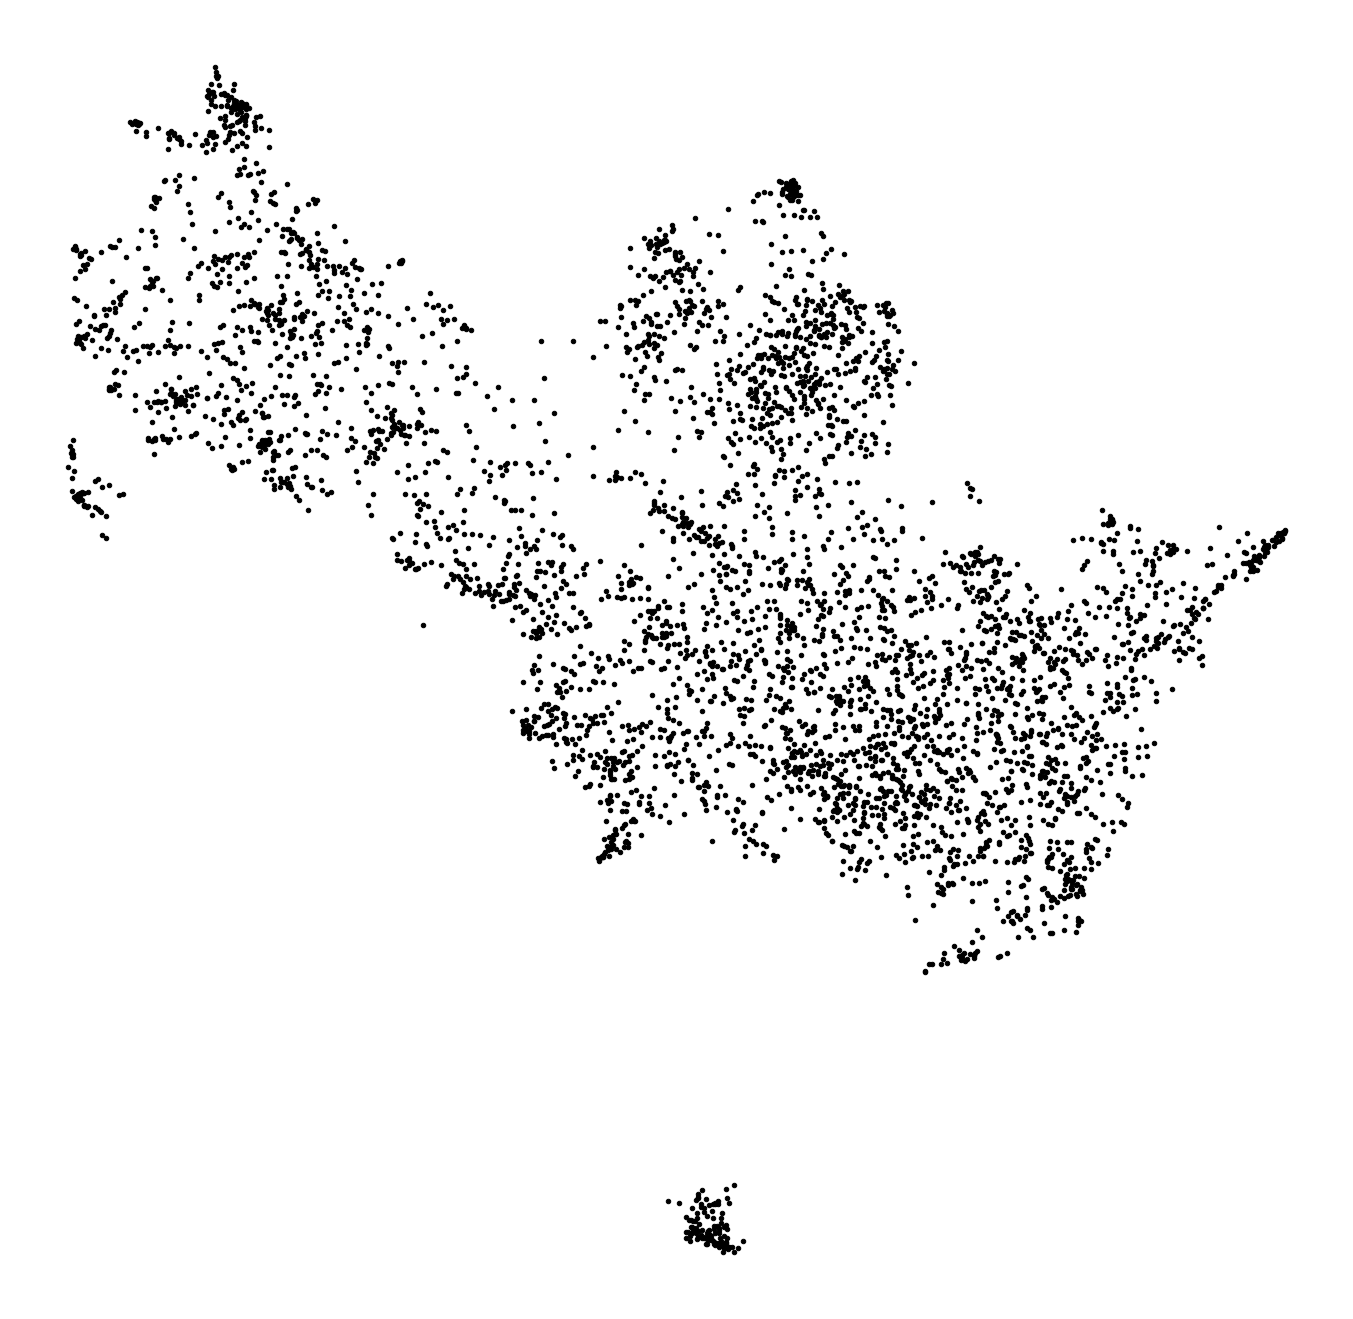

time: 807 ms


In [25]:
# Plot for presentation
plt.figure(figsize=(24,24), facecolor='w')
plt.scatter(embedding_cull[:,0], embedding_cull[:,1],s=20,c='k')
plt.axis('off')
plt.show()

In [26]:
# Plotly
layout = go.Layout(
    autosize=False,
    width=800,
    height=800,
    hovermode="closest"
)

data = [go.Scatter(
                x=embedding_cull[:,0],
                y=embedding_cull[:,1],
                text=df[idx].textwrap,
                mode='markers',
                marker=dict(
                        size=3,
                        colorscale=matplotlib_to_plotly(plt.cm.viridis_r, 255),
                        color=0,
                        showscale=False
                )
)]

fig = go.Figure(data=data, layout=layout)

p = iplot(fig)

time: 381 ms


In [27]:
# Save this version, for github &  workshop
plot(fig, filename='output/viz2-gopro.html')

'output/viz2-gopro.html'

time: 352 ms
